In [4]:
import os
import sys
import cv2
import json
import pathlib

import numpy as np
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
class_label_path = os.path.join(os.getcwd(), 'class_lists', 'labelled_class_list.txt')
with open(class_label_path, 'r') as f:
    class_list = [line.rstrip() for line in f]

class_labels_dict = {k:v.lower() for k, v in enumerate(class_list)}  ###List to dict
class_labels_dict

{0: 'bicycle', 1: 'bike', 2: 'bus', 3: 'car', 4: 'cng', 5: 'truck'}

In [19]:
yolo_classes_path = os.path.join(os.getcwd(), 'class_lists', 'yolo_classes.txt')
with open(yolo_classes_path, 'r') as f:
    yolo_class_dict = json.loads(f.read())
    
yolo_class_dict

{'all': None,
 'person': 0,
 'bicycle': 1,
 'car': 2,
 'motorcycle': 3,
 'airplane': 4,
 'bus': 5,
 'train': 6,
 'truck': 7,
 'boat': 8,
 'traffic light': 9,
 'fire hydrant': 10,
 'stop sign': 11,
 'parking meter': 12,
 'bench': 13,
 'bird': 14,
 'cat': 15,
 'dog': 16,
 'horse': 17,
 'sheep': 18,
 'cow': 19,
 'elephant': 20,
 'bear': 21,
 'zebra': 22,
 'giraffe': 23,
 'backpack': 24,
 'umbrella': 25,
 'handbag': 26,
 'tie': 27,
 'suitcase': 28,
 'frisbee': 29,
 'skis': 30,
 'snowboard': 31,
 'sports ball': 32,
 'kite': 33,
 'baseball bat': 34,
 'baseball glove': 35,
 'skateboard': 36,
 'surfboard': 37,
 'tennis racket': 38,
 'bottle': 39,
 'wine glass': 40,
 'cup': 41,
 'fork': 42,
 'knife': 43,
 'spoon': 44,
 'bowl': 45,
 'banana': 46,
 'apple': 47,
 'sandwich': 48,
 'orange': 49,
 'broccoli': 50,
 'carrot': 51,
 'hot dog': 52,
 'pizza': 53,
 'donut': 54,
 'cake': 55,
 'chair': 56,
 'couch': 57,
 'potted plant': 58,
 'bed': 59,
 'dining table': 60,
 'toilet': 61,
 'tv': 62,
 'laptop':

### Read YOLO annotations path

In [20]:
dir_dict = {}
for item in class_list:
    annotations = glob(os.path.join("C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis","Custom_dataset",item,"images","*.txt"))
    dir_dict[item] = {}
    dir_dict[item]["annotations"] = annotations


### Read Pictures path

In [21]:
img_dict = {}
for item in class_list:
    path = glob(os.path.join("C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis","Custom_dataset",item,"yolo_annotations","*.[jp][pn]g"))
    img_dict[item] = {}
    img_dict[item]["img_path"] = path

In [22]:
class yolo_parser:
    def __init__(self, class_labels, yolo_classes):
        self.class_labels = class_labels
        self.yolo_classes = yolo_classes
        self.reverse_yolo_classes = {v: k for k, v in yolo_classes.items()}
        
    def read_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.img = img
        return img
        
    def read_yolo(self, yolo_path):
        with open(yolo_path, 'r') as f:
            data = [line.rstrip() for line in f]
        return data
    
    def map_to_yolo_labels(self, label):
        return self.yolo_classes[self.class_labels[label]]
        
    def get_coordinates(self, image_path, yolo_path):
        '''
            Input: image path, yolo_label file path
            Output: list -> [[class_label, coordinates],...] 
                e.g. [[0, 5, 5, 10, 10])   #label, x1, y1, x2, y2
                
            Reference link: 
            https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
        '''
        
        img = self.read_image(image_path)
        dh, dw, _ = img.shape
        
        data = self.read_yolo(yolo_path)
        
        result = []
        
        for dt in data:

            # Split string to float
            label, x, y, w, h = map(float, dt.split(' '))
            label = self.map_to_yolo_labels(label)
            
            # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
            # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
            x1 = int((x - w / 2) * dw)
            y1 = int((y - h / 2) * dh)
            x2 = int((x + w / 2) * dw)
            y2 = int((y + h / 2) * dh)
    
            if x1 < 0:
                x1 = 0
            if y1 < 0:
                y1 = 0
            if x2 > dw - 1:
                x2 = dw - 1
            if y2 > dh - 1:
                y2 = dh - 1
            
            
            result.append([label, x1, y1, x2, y2])
            
        return result
    
    def draw_bboxes(self, data):
        
        for label, x1, y1, x2, y2 in data:
            
            # draw bbox rectangle
            color = (248, 255, 6) if label < 5 else (6, 255, 31)
            thickness = 3
            cv2.rectangle(self.img, (x1, y1), (x2, y2), color, thickness)
            
            # put label text
            text = self.reverse_yolo_classes[label]
            font = cv2.FONT_HERSHEY_SIMPLEX
            origin = (x1, y1)
            fontScale = 1
            color = (255, 0, 0)
            thickness = 3
            cv2.putText(self.img, text, origin, font, fontScale, color, thickness, cv2.LINE_AA)
            
        return self.img

In [23]:
obj = yolo_parser(class_labels_dict, yolo_class_dict)

In [24]:
_images = ['C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (100).jpg',
'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (101).jpg',
'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (102).jpg',
'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (103).jpg',
'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (104).jpg']
_labels = ['C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/yolo_annotations/bicycle (100).txt',
           'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/yolo_annotations/bicycle (101).txt',
           'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/yolo_annotations/bicycle (102).txt',
           'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/yolo_annotations/bicycle (103).txt',
           'C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/yolo_annotations/bicycle (104).txt']



### Visualise Ground Truth

C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (100).jpg
C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (101).jpg
C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (102).jpg
C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (103).jpg
C:/Users/Pc-Klinik/Desktop/Object_detection_Thesis/Custom_dataset/Bicycle/images/bicycle (104).jpg


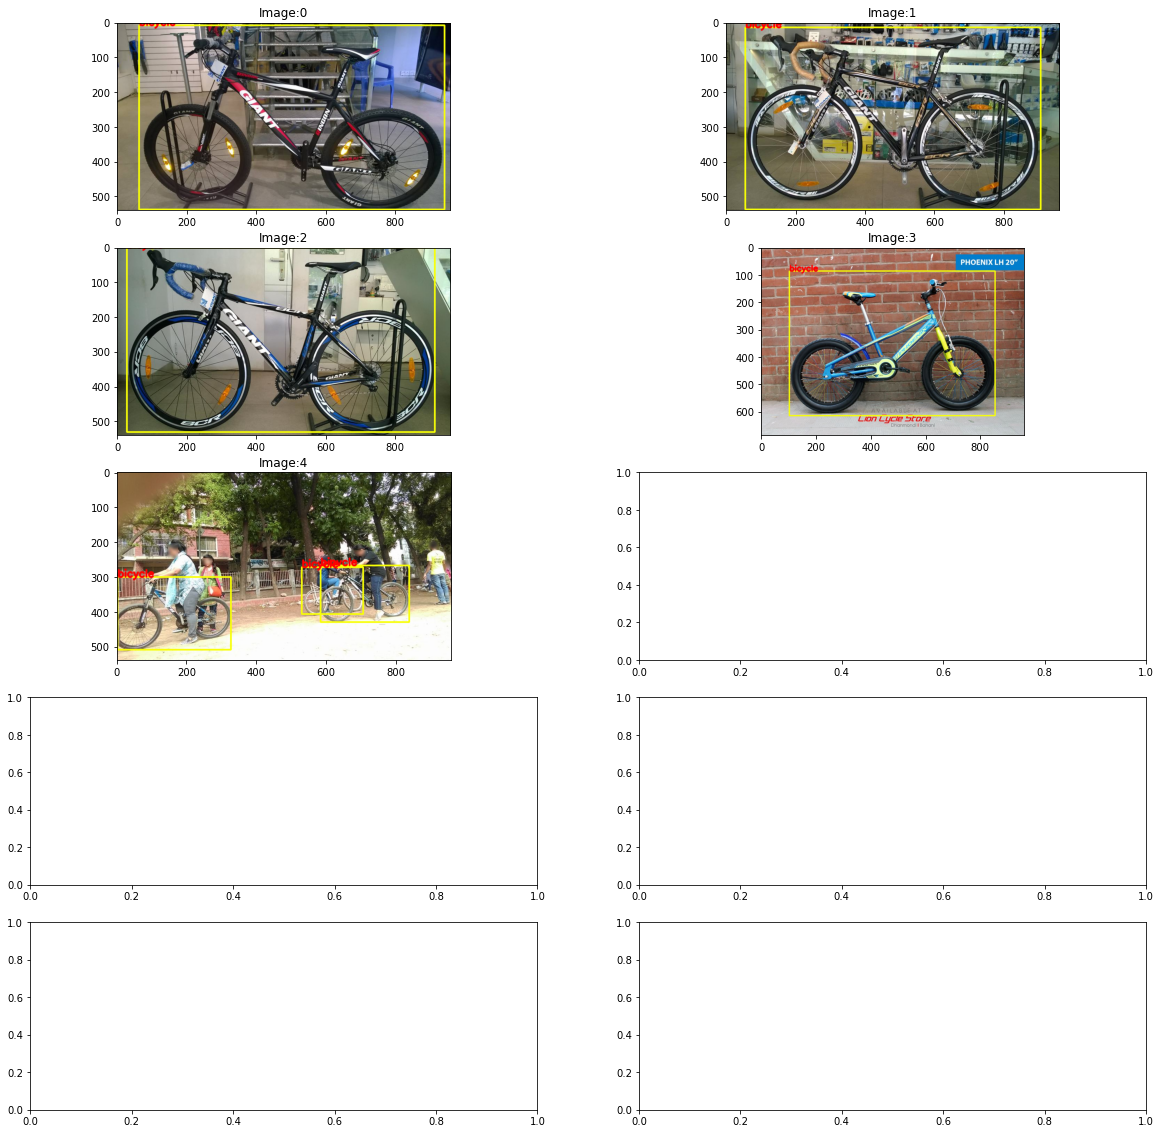

In [26]:
fig, axes = plt.subplots(5,2, figsize=(20,20))
axis_iter = iter(axes.ravel())
gts = []

for idx, (image_path, yolo_path) in enumerate(zip(_images, _labels)):
    
    print(image_path)
        
    data_gt = obj.get_coordinates(image_path, yolo_path)
    img = obj.draw_bboxes(data_gt)
    
    for gt in data_gt:
        gts.append([idx] + gt)
        
    ax = next(axis_iter)
    ax.imshow(img)
    ax.set_title('Image:'+str(idx))

In [1]:
for i,m in enumerate(img_dict):
    
#     print(i,m)
    for a,pth in enumerate(img_dict[m]["image_path"]):
         print(a,pth)
#         for b,p in enumerate(pth):
#             print(b,p)

NameError: name 'img_dict' is not defined